In [1]:
import seaborn
import pandas

%pylab inline
#%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


In [227]:
# 500bp scanning size
!~/pkg/PhiPack/src/Profile -v -w 100 -n 500 -m 100 -f data/refcov89_fullgenome_alignment.fasta &> /dev/null
!mv Profile.csv Profile_w500.csv
!mv Profile.log Profile_w500.log
# 1000bp scanning size
!~/pkg/PhiPack/src/Profile -v -w 100 -n 1000 -m 25 -f data/refcov89_fullgenome_alignment.fasta &> /dev/null
!mv Profile.csv Profile_w1000.csv
!mv Profile.log Profile_w1000.log
# 5000bp scanning size
!~/pkg/PhiPack/src/Profile -v -w 100 -n 5000 -m 100 -f data/refcov89_fullgenome_alignment.fasta &> /dev/null
!mv Profile.csv Profile_w5000.csv
!mv Profile.log Profile_w5000.log

Text(0, 0.5, '$\\phi_w$')

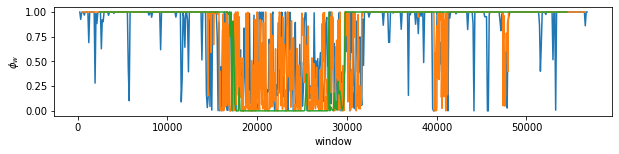

In [2]:
figure( figsize=( 10, 2 ) )

df500 = pandas.read_csv( 'Profile_w500.csv', header=None )
df500.columns = [ 'window', 'PHI' ]

df1000 = pandas.read_csv( 'Profile_w1000.csv', header=None )
df1000.columns = [ 'window', 'PHI' ]

df5000 = pandas.read_csv( 'Profile_w5000.csv', header=None )
df5000.columns = [ 'window', 'PHI' ]

seaborn.lineplot( df500.window,  df500.PHI )
seaborn.lineplot( df1000.window, df1000.PHI )
seaborn.lineplot( df5000.window, df5000.PHI )

ylabel( r'$\phi_w$' )

In [3]:
from Bio import SeqIO

with open( 'data/refcov89_fullgenome_alignment.fasta' ) as f :
    for record in SeqIO.parse( f, format='fasta' ) :
        if record.id.split('|')[0] == 'NC_045512' : break
            
len(record)

57049

Map $\phi_w$ values from alignment coordinates to reference genome coordinates.

Text(0, 0.5, 'alignment coordinates')

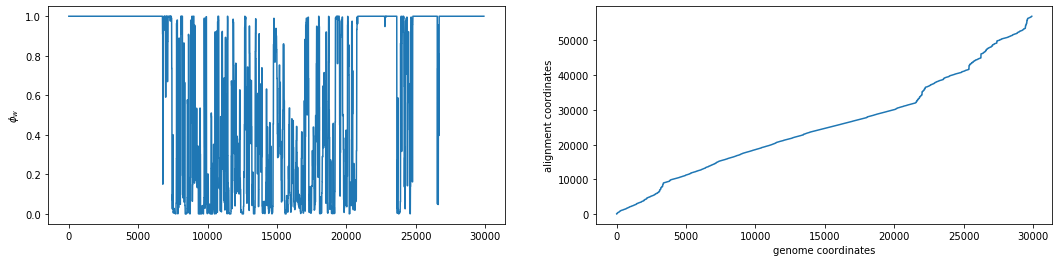

In [9]:
figure( figsize=( 18, 4 ) )

mapping = zeros(len(record))
mapping[:] = 1
gapping = []

for n,row in df1000.iterrows() :
    mapping[ int(row.window - 500) : int(row.window + 499) ] = row.PHI

PHI = zeros( len( str( record.seq).replace('-','') ) )
j = 0
for n,i in enumerate( record.seq ) :
    if i != '-' :
        gapping.append(n)
        PHI[j] = mapping[n]
        j = j+1
    
subplot( 1, 2, 1 )
seaborn.lineplot( range(len(PHI)), PHI )
ylabel( r'$\phi_w$' )
subplot( 1, 2, 2 )
plot( gapping )
xlabel( 'genome coordinates' )
ylabel( 'alignment coordinates' )

In [5]:
import gffpandas.gffpandas as gffpd

annotations = gffpd.read_gff3( 'data/annotations.gff' )
annotations.df.head()

,seq_id,source,type,start,end,score,strand,phase,attributes
0,NC_045512.2,RefSeq,region,1,29903,.,+,.,ID=NC_045512.2:1..29903;Dbxref=taxon:2697049;c...
1,NC_045512.2,RefSeq,five_prime_UTR,1,265,.,+,.,ID=id-NC_045512.2:1..265;gbkey=5'UTR
2,NC_045512.2,RefSeq,gene,266,21555,.,+,.,ID=gene-GU280_gp01;Dbxref=GeneID:43740578;Name...
3,NC_045512.2,RefSeq,CDS,266,13468,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...
4,NC_045512.2,RefSeq,CDS,13468,21555,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...


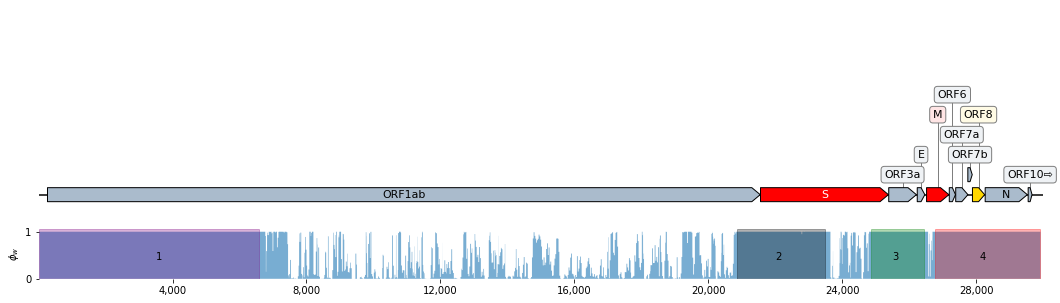

In [10]:
from dna_features_viewer import GraphicFeature, GraphicRecord

fig, (ax1, ax2) = subplots(
    2, 1, figsize=(18, 5), sharex=True, gridspec_kw={"height_ratios": [4, 1]}
)

# Feature map

replication = [ 'ORF1ab' ]
target      = [ 'ORF8' ]
surface     = [ 'S', 'M' ]

features = []

for i,row in annotations.filter_feature_of_type( ['gene'] ).df.iterrows() :
    attributes = { a.split('=')[0]:a.split('=')[1] for a in row.attributes.split(';') }
    if attributes['Name'] in target        : color = '#ffd700'
    #elif attributes['Name'] in replication : color = '#aabbcc'
    elif attributes['Name'] in surface     : color = '#ff0000'
    else                                   : color = '#aabbcc'
    features.append( GraphicFeature( start=row.start,
                                     end=row.end,
                                     strand=+1,
                                     color=color,
                                     label=attributes['Name'] ) )

grecord = GraphicRecord(sequence_length=30000, features=features)
grecord.plot( ax=ax1, with_ruler=False, strand_in_label_threshold=4 )

# Track plot

xx = np.arange( len(PHI) )
ax2.fill_between( xx + 25, PHI, alpha=0.6 )
ax2.set_ylim( bottom=0 )
ax2.set_ylabel( r'$\phi_w$' )
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().set_ticks([4000,8000,12000,16000,20000,24000,28000])

axvspan( 0,     6570, alpha=.3, color='purple' )
axvspan( 20850, 23500, alpha=.3, color='black' )
axvspan( 24850, 26450, alpha=.3, color='green' )
axvspan( 26760, len(PHI), alpha=.3, color='red' )

ax2.text(  3500, 0.4, '1' )
ax2.text( 22000, 0.4, '2' )
ax2.text( 25500, 0.4, '3' )
ax2.text( 28100, 0.4, '4' )

savefig( 'figures/breakpoints.pdf' )

In [11]:
# non-recombining block coordinates in SARS-CoV-2 reference genome coordinates
block1g = ( 0,      6570        )
block2g = ( 20850, 23500        )
block3g = ( 24850, 26450        )
block4g = ( 26760, len(PHI) - 1 )
blocksg = [ block1g, block2g, block3g, block4g ]

# non-recombining block coordinates in alignment coordinates
blocksa = [ ( gapping[a], gapping[b] ) for a,b in blocksg ]
block1a, block2a, block3a, block4a = blocksa

In [12]:
from Bio import SeqIO

for n,(start,stop) in enumerate( blocksa ) :
    with open( 'data/block_' + str(n+1) + '_aln.fasta', 'w' ) as output :
        with open( 'data/refcov89_fullgenome_alignment.fasta' ) as f :
            for record in SeqIO.parse( f, format='fasta' ) :
                output.write( record[ start:stop ].format( 'fasta' ) )

'>NC_045512|BetaCoV|Human_SARS-CoV-2_strain_Wuhan-Hu-1\nTATAACAATACTAGATGGAA\n'

([<matplotlib.axis.XTick at 0x7f15b096f8d0>,
 <a list of 23 Text xticklabel objects>)

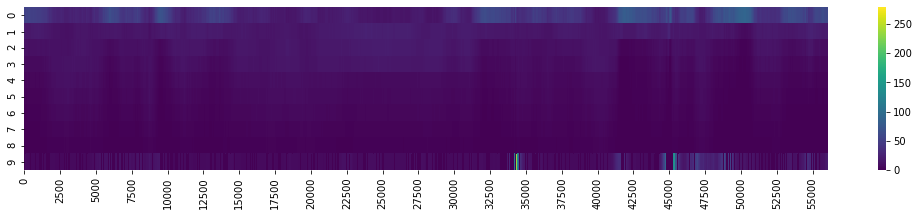

In [242]:
incompatibility_scores = []
centers = []

for i,block in enumerate( open( 'Profile_w1000.log' ).read().split( 'Checking for recombination at ' ) ) :
    if i == 0 : continue # skip the log header
    block = block.split('\n')
    center, X, start, X, end = block[0].split()
    centers.append(center)
    scores = []
    for j in range(10) :
        score = block[3+j][6:10]
        try :
            scores.append( float(score) )
        except :
            scores.append( 0 )
    incompatibility_scores.append( scores )

incompatibility_scores = array( incompatibility_scores ).T

figure( figsize=(18,3) )
seaborn.heatmap( incompatibility_scores, cmap='viridis' )
xticks(       [ i for i in range( 0, len(centers), 100 ) ], 
    labels=[ 25*i for i in range( 0, len(centers), 100 ) ] )